# Functions

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.model_selection import train_test_split

import os

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape,Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping

import pandas as pd
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.model_selection import train_test_split, LeaveOneOut

import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Code

In [2]:


def get_val_results():
   
    main_data = pd.read_excel('Validation_Interpolate_Median.xlsx')

  
    results_dir = "./Results_Validation_Median"
    test_data_dir = "./ExcelsPrecision_Median"


    def format_parameters(param):
        return param.replace('_', '', 1)

    def format_frame(frame):
        frame_num = int(frame.split('_')[-1])
        return f"result_frame_{frame_num:06d}",frame_num


    filtered_data = main_data[main_data['Result'] == 1]


    combined_data = []

 
    for _, row in filtered_data.iterrows():
        video = row['Video']
        raw_frame = row['Frame']
        frame, frame_num = format_frame(raw_frame)
        params = format_parameters(row['Parameters'])

    
        image_path = os.path.join(results_dir, video, f"{video}_Results_bw{params}", f"{frame}.png")
        test_data_path = os.path.join(test_data_dir, f"{video}_{params}_comapprox_post_processed_median.xlsx")

 
        if os.path.exists(test_data_path):
            test_data = pd.read_excel(test_data_path, index_col=0)  
            if frame_num in test_data.index:  
                test_row = test_data.loc[frame_num]
                combined_data.append({
                    'Image Path': image_path,
                    'Video': video,
                    'Frame': frame,
                    'Parameters': params,
                    'center_y(ccol)': test_row['center_y(ccol)'],
                    'center_x(crow)': test_row['center_x(crow)'],
                    'circle_radius': test_row['circle_radius']
                })
            else:
                print(f"Warning: Frame {frame_num} not found in {test_data_path}")
        else:
            print(f"Warning: Test data file not found for {test_data_path}")

    # Create DataFrame from combined data
    result_df = pd.DataFrame(combined_data)

    # Save to Excel
    output_path = "combined_results.xlsx"
    result_df.to_excel(output_path, index=False)
    print(f"Combined results saved to {output_path}")


In [4]:



def build_autoencoder(input_shape=(256, 256, 1)):
    input_img = Input(shape=input_shape, name='input_image')

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Flatten(name='encoded_features')(x)

    # Predictions
    radius_pred = Dense(1, activation='linear', name='radius_output')(encoded)
    ccol_pred = Dense(1, activation='linear', name='ccol_output')(encoded)
    crow_pred = Dense(1, activation='linear', name='crow_output')(encoded)

    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)                # 8x8
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)                # 16x16
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)                # 64x64
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)                # 128x128
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)                # 256x256
    x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='image_output')(x)

    autoencoder = Model(inputs=input_img, outputs=[decoded, radius_pred, ccol_pred, crow_pred], name='autoencoder')
    return autoencoder



def train_autoencoder(autoencoder, x_train, radii_train, x_val, radii_val, ccol_train, crow_train, ccol_val, crow_val, epochs=50, batch_size=32):
    autoencoder.compile(
        optimizer='adam',
        loss={
            'image_output': 'mse',        # For reconstructed images
            'radius_output': 'mse',       # For radii
            'ccol_output': 'mse',         # Center Y
            'crow_output': 'mse'          # Center X
        }
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = autoencoder.fit(
    x_train,
    {
        'image_output': x_train,
        'radius_output': radii_train,
        'ccol_output': ccol_train,
        'crow_output': crow_train
    },
    validation_data=(
        x_val,
        {
            'image_output': x_val,
            'radius_output': radii_val,
            'ccol_output': ccol_val,
            'crow_output': crow_val
        }
    ),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping]
)


    autoencoder.summary()

    return history



In [4]:



def build_autoencoder(input_shape=(256, 256, 1)):
    input_img = Input(shape=input_shape, name='input_image')

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Flatten(name='encoded_features')(x)

    # Predictions
    circle_info = Dense(3, activation='linear', name='circle_info_output')(encoded)

    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)                # 8x8
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)                # 16x16
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)                # 64x64
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)                # 128x128
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)                # 256x256
    x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='image_output')(x)

    autoencoder = Model(inputs=input_img, outputs=[decoded, circle_info], name='autoencoder')
    return autoencoder



def train_autoencoder(autoencoder, x_train, radii_train, ccol_train, crow_train, x_val, radii_val, ccol_val, crow_val, epochs=50, batch_size=32):
    # Combine radii, ccol, and crow into a single training and validation target
    circle_train = np.stack([radii_train, ccol_train, crow_train], axis=1).squeeze(-1)
    circle_val = np.stack([radii_val, ccol_val, crow_val], axis=1).squeeze(-1)

    print(f'circle_train shape: {circle_train.shape}')
    print(f'circle_val shape: {circle_val.shape}')

    # Compile the autoencoder
    autoencoder.compile(
        optimizer='adam',
        loss={
            'image_output': 'mse',        # Loss for image reconstruction
            'circle_info_output': 'mse'  # Loss for circle parameter regression
        }
    )

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the autoencoder
    history = autoencoder.fit(
        x_train,
        {
            'image_output': x_train,     # Image reconstruction target
            'circle_info_output': circle_train  # Circle parameters target
        },
        validation_data=(
            x_val,
            {
                'image_output': x_val,    # Validation target for reconstructed images
                'circle_info_output': circle_val  # Validation target for circle parameters
            }
        ),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping]
    )

    autoencoder.summary()
    return history



In [ ]:
# def build_autoencoder(input_shape=(256, 256, 1)):
   
#     input_img = Input(shape=input_shape, name='input_image')


#     x = Conv2D(16, (3, 3), activation='relu', padding='same', strides=(2, 2))(input_img)
#     x = Conv2D(32, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
#     encoded = Flatten(name='encoded_features')(x)
#     # Use Reshape instead of Flatten
#     # encoded= Reshape((4, 4, 64), name='encoded_features')(x)



#     radius_pred = Dense(1, activation='linear', name='radius_output')(encoded)
#     ccol_pred = Dense(1, activation='linear', name='ccol_output')(encoded)
#     crow_pred = Dense(1, activation='linear', name='crow_output')(encoded)


#     x = Dense(256, activation='relu')(encoded)
#     x = Reshape((4, 4, 16))(x)  


#     x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)  # 128x128
#     x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)  # 256x256
#     decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='image_output')(x)


    
#     autoencoder = Model(inputs=input_img, outputs=[decoded, radius_pred,ccol_pred,crow_pred], name='autoencoder')




  
#     # autoencoder = Model(inputs=input_img, outputs=[decoded, radius_pred], name='autoencoder')
#     return autoencoder
# shit results

In [2]:
def build_autoencoder(input_shape=(256, 256, 1)):
    input_img = Input(shape=input_shape, name='input_image')

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)  # Down to 128x128
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)  # Down to 64x64
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    # Flatten features for predictions
    encoded = Flatten(name='encoded_features')(x)

    # Predict key features
    radius_pred = Dense(1, activation='linear', name='radius_output')(encoded)
    ccol_pred = Dense(1, activation='linear', name='ccol_output')(encoded)
    crow_pred = Dense(1, activation='linear', name='crow_output')(encoded)

    # Efficient Decoder with Conv2DTranspose
    x = Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu')(x)  
    x = Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = Conv2DTranspose(16, (3, 3), strides=2, padding='same', activation='relu')(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='image_output')(x)

    # Define the model
    autoencoder = Model(inputs=input_img, outputs=[decoded, radius_pred, ccol_pred, crow_pred], name='autoencoder')

    return autoencoder


In [2]:
def build_autoencoder(input_shape=(256, 256, 1)):
    input_img = Input(shape=input_shape, name='input_image')

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)  # Down to 128x128
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)  # Down to 64x64

    # Flatten features for predictions
    encoded = Flatten(name='encoded_features')(x)

    # Predict key features
    radius_pred = Dense(1, activation='linear', name='radius_output')(encoded)
    ccol_pred = Dense(1, activation='linear', name='ccol_output')(encoded)
    crow_pred = Dense(1, activation='linear', name='crow_output')(encoded)

    x = Dense(1024, activation='relu')(encoded)
    x = Reshape((4, 4, 64))(x)

    # Efficient Decoder with Conv2DTranspose
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)                # 8x8
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)                # 16x16
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)                # 64x64
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)                # 128x128
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)                # 256x256
    x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='image_output')(x)

    # Define the model
    autoencoder = Model(inputs=input_img, outputs=[decoded, radius_pred, ccol_pred, crow_pred], name='autoencoder')

    return autoencoder


In [6]:



df = pd.read_excel('combined_results.xlsx')

image_paths = df['Image Path'].tolist()  
radii = df['circle_radius'].values   
ccols = df['center_y(ccol)'].values 
crows = df['center_x(crow)'].values

radii = radii.reshape(-1, 1)  # Ensure shape: (num_samples, 1)
ccols = ccols.reshape(-1, 1)  # Ensure shape: (num_samples, 1)
crows = crows.reshape(-1, 1)  # Ensure shape: (num_samples, 1)


img_height, img_width = 256, 256  
images = []

for path in image_paths:
  
    img = load_img(path, target_size=(img_height, img_width), color_mode='grayscale')
    img_array = img_to_array(img) / 255.0  
    images.append(img_array)


images = np.array(images)  # Shape: (num_samples, img_height, img_width, 1)
radii = radii.reshape(-1, 1)  # Shape: (num_samples, 1)


x_train, x_test, radii_train, radii_test,ccol_train,ccol_test,crow_train,crow_test = train_test_split(
    images, radii,ccols,crows, test_size=0.2, random_state=42
)



autoencoder = build_autoencoder(input_shape=(img_height, img_width, 1))  # Function from earlier code
# history = train_autoencoder(autoencoder, x_train, radii_train, x_val, radii_val, epochs=50, batch_size=32)
# history = train_autoencoder(autoencoder, x_train, radii_train, x_val, radii_val,ccol_train,crow_train,ccol_val,crow_val, epochs=50, batch_size=32)
autoencoder.compile(
        optimizer='adam',
        loss={
            'image_output': 'mse',
            'radius_output': 'mse',
            'ccol_output': 'mse',
            'crow_output': 'mse'
        }
    )

    # print(images_test.shape)  # Should be (num_samples, 256, 256, 1)
    # print(radii_train.shape)   # Should be (num_samples, 1)
    # print(ccol_train.shape)    # Should be (num_samples, 1)
    # print(crow_train.shape)    # Should be (num_samples, 1)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = autoencoder.fit(
    x_train,
    {
        'image_output': x_train, 
        'radius_output': radii_train,
        'ccol_output':ccol_train,
        'crow_output':crow_train
    },
    validation_data=(x_test,{
        'image_output': x_test,
        'radius_output': radii_test,
        'ccol_output': ccol_test,
        'crow_output': crow_test
    }),
    # validation_split=0.1,
    epochs=50,
    # batch_size=32,
    batch_size=5,
    callbacks=[early_stopping],
    verbose=1
)


autoencoder.save('diffraction_autoencoder_center.h5')


test_images = x_test[:10]  
reconstructed_images, predicted_radii,pred_ccol,pred_crow = autoencoder.predict(test_images)


print("Predicted Radii:", predicted_radii.flatten())


Epoch 1/50


InvalidArgumentError: Graph execution error:

Detected at node gradient_tape/compile_loss/mse_2/sub/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Tautvydas\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "C:\Users\Tautvydas\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\Tautvydas\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "C:\Users\Tautvydas\AppData\Roaming\Python\Python312\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "c:\Users\Tautvydas\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 641, in run_forever

  File "c:\Users\Tautvydas\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 1987, in _run_once

  File "c:\Users\Tautvydas\AppData\Local\Programs\Python\Python312\Lib\asyncio\events.py", line 88, in _run

  File "C:\Users\Tautvydas\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "C:\Users\Tautvydas\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "C:\Users\Tautvydas\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "C:\Users\Tautvydas\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "C:\Users\Tautvydas\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "C:\Users\Tautvydas\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "C:\Users\Tautvydas\AppData\Roaming\Python\Python312\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\Tautvydas\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "C:\Users\Tautvydas\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "C:\Users\Tautvydas\AppData\Roaming\Python\Python312\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "C:\Users\Tautvydas\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "C:\Users\Tautvydas\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "C:\Users\Tautvydas\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_49576\337168989.py", line 53, in <module>

  File "c:\Users\Tautvydas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Tautvydas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 320, in fit

  File "c:\Users\Tautvydas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 121, in one_step_on_iterator

  File "c:\Users\Tautvydas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 108, in one_step_on_data

  File "c:\Users\Tautvydas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 70, in train_step

Incompatible shapes: [5,256,256,1] vs. [5,1]
	 [[{{node gradient_tape/compile_loss/mse_2/sub/BroadcastGradientArgs}}]] [Op:__inference_one_step_on_iterator_25466]

In [9]:
test_images = x_test[:10]  
reconstructed_images, predicted_radii,pred_ccol,pred_crow = autoencoder.predict(test_images)


print("Predicted Radii:", pred_crow.flatten())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
Predicted Radii: [39.261803 36.234627 37.071953 38.464817 39.264908 37.613297 38.629036
 37.367546 34.489403 33.99919 ]


In [5]:
df = pd.read_excel('combined_results.xlsx')

image_paths = df['Image Path'].tolist()  
img_height, img_width = 256, 256  
images = []

for path in image_paths:
  
    img = load_img(path, target_size=(img_height, img_width), color_mode='grayscale')
    img_array = img_to_array(img) / 255.0  
    images.append(img_array)


radii = df['circle_radius'].values   
ccol = df['center_y(ccol)'].values
crow = df['center_x(crow)'].values

images = np.array(images)  # Shape: (num_samples, img_height, img_width, 1)
radii = radii.reshape(-1, 1)  # Shape: (num_samples, 1)
ccol = ccol.reshape(-1, 1)
crow = crow.reshape(-1, 1)

loo=LeaveOneOut()

for i, (train_index, test_index) in enumerate(loo.split(df)):
    # print(f"Fold {i}:")

    # print(f"  Train: index={train_index}")

    # print(f"  Test:  index={test_index}")
    # images_train = [images[j] for j in train_index]
    images_train = images[train_index]
    images_test=images[test_index]

    # radii_train = [radii[j] for j in train_index]
    radii_train = radii[train_index]
    radii_test=radii[test_index]
                                 
    # ccol_train = [ccol[j] for j in train_index]
    ccol_train = ccol[train_index]
    ccol_test=ccol[test_index]
                                 
    # crow_train = [crow[j] for j in train_index]
    crow_train = crow[train_index]
    crow_test=crow[test_index]
    # print(image_paths_train)

    autoencoder = build_autoencoder(input_shape=(img_height, img_width, 1))

    autoencoder.compile(
        optimizer='adam',
        loss={
            'image_output': 'mse',
            'radius_output': 'mse',
            'ccol_output': 'mse',
            'crow_output': 'mse'
        }
    )

    # print(images_test.shape)  # Should be (num_samples, 256, 256, 1)
    # print(radii_train.shape)   # Should be (num_samples, 1)
    # print(ccol_train.shape)    # Should be (num_samples, 1)
    # print(crow_train.shape)    # Should be (num_samples, 1)

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = autoencoder.fit(
        images_train,
        {
            'image_output': images_train, 
            'radius_output': radii_train,
            'ccol_output':ccol_train,
            'crow_output':crow_train
        },
        validation_data=(images_test,{
            'image_output': images_test,
            'radius_output': radii_test,
            'ccol_output': ccol_test,
            'crow_output': crow_test
        }),
        validation_split=0.1,
        epochs=50,
        # batch_size=32,
        batch_size=1,
        callbacks=[early_stopping],
        verbose=1
    )

    # Save the model for the current fold
    model_path = os.path.join('models', f'autoencoder_fold_{i+1}.h5')
    autoencoder.save(model_path)
    print(f"Saved model to {model_path}")

Epoch 1/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - ccol_output_loss: 29.4556 - crow_output_loss: 170.9219 - image_output_loss: 20424.4668 - loss: 21933.5078 - radius_output_loss: 1308.6598 - val_ccol_output_loss: 0.0747 - val_crow_output_loss: 2.0391 - val_image_output_loss: 20019.3496 - val_loss: 20035.8848 - val_radius_output_loss: 14.4222
Epoch 2/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - ccol_output_loss: 0.1842 - crow_output_loss: 10.3597 - image_output_loss: 20250.4238 - loss: 20313.1328 - radius_output_loss: 52.1674 - val_ccol_output_loss: 0.1145 - val_crow_output_loss: 4.1299 - val_image_output_loss: 20019.3477 - val_loss: 20029.2031 - val_radius_output_loss: 5.6096
Epoch 3/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 18s 81ms/step - ccol_output_loss: 0.2403 - crow_output_loss: 7.6662 - image_output_loss: 20360.2246 - loss: 20391.4746 - radius_output_loss: 23.3509 - val_ccol_output_loss: 0.3222 - val_crow_output_loss: 3.5913 - val_image_output_loss: 20019.3477 - val_loss: 20059.05

Saved model to models\autoencoder_fold_1.h5
Epoch 1/50
 45/221 ━━━━━━━━━━━━━━━━━━━━ 15s 86ms/step - ccol_output_loss: 27.1189 - crow_output_loss: 678.3806 - image_output_loss: 19679.3145 - loss: 25613.7832 - radius_output_loss: 5228.9697

KeyboardInterrupt: 

In [2]:
autoencoder.summary()

NameError: name 'autoencoder' is not defined

In [5]:



df = pd.read_excel('combined_results.xlsx')


image_paths = df['Image Path'].tolist()  
radii = df['circle_radius'].values   
ccol = df['center_y(ccol)'].values
crow = df['center_x(crow)'].values


img_height, img_width = 256, 256  
images = []

for path in image_paths:
  
    img = load_img(path, target_size=(img_height, img_width), color_mode='grayscale')
    img_array = img_to_array(img) / 255.0  
    images.append(img_array)


images = np.array(images)  # Shape: (num_samples, img_height, img_width, 1)
radii = radii.reshape(-1, 1)  # Shape: (num_samples, 1)
ccol = ccol.reshape(-1, 1)
crow = crow.reshape(-1, 1)


x_train, x_val, radii_train, radii_val,ccol_train,ccol_val,crow_train,crow_val = train_test_split(
    images, radii,ccol,crow, test_size=0.2, random_state=42
)

autoencoder = build_autoencoder(input_shape=(img_height, img_width, 1))  # Function from earlier code
history = train_autoencoder(autoencoder, x_train, radii_train,ccol_train,crow_train, x_val, radii_val,ccol_val,crow_val, epochs=50, batch_size=32)

autoencoder.save('diffraction_autoencoder_center_merged.keras')


test_images = x_val[:10]  
reconstructed_images, predicted_radii = autoencoder.predict(test_images)


print("Predicted Radii:", predicted_radii.flatten())


circle_train shape: (177, 3)
circle_val shape: (45, 3)
Epoch 1/50


InvalidArgumentError: Graph execution error:

Detected at node gradient_tape/compile_loss/mse_1/sub/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Tautvydas\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "C:\Users\Tautvydas\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\Tautvydas\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "C:\Users\Tautvydas\AppData\Roaming\Python\Python312\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "c:\Users\Tautvydas\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 641, in run_forever

  File "c:\Users\Tautvydas\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 1987, in _run_once

  File "c:\Users\Tautvydas\AppData\Local\Programs\Python\Python312\Lib\asyncio\events.py", line 88, in _run

  File "C:\Users\Tautvydas\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "C:\Users\Tautvydas\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "C:\Users\Tautvydas\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "C:\Users\Tautvydas\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "C:\Users\Tautvydas\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "C:\Users\Tautvydas\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "C:\Users\Tautvydas\AppData\Roaming\Python\Python312\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\Tautvydas\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "C:\Users\Tautvydas\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "C:\Users\Tautvydas\AppData\Roaming\Python\Python312\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "C:\Users\Tautvydas\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "C:\Users\Tautvydas\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "C:\Users\Tautvydas\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_63656\70066612.py", line 31, in <module>

  File "C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_63656\2032369659.py", line 55, in train_autoencoder

  File "c:\Users\Tautvydas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Tautvydas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 320, in fit

  File "c:\Users\Tautvydas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 121, in one_step_on_iterator

  File "c:\Users\Tautvydas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 108, in one_step_on_data

  File "c:\Users\Tautvydas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 70, in train_step

Incompatible shapes: [32,256,256,1] vs. [32,3]
	 [[{{node gradient_tape/compile_loss/mse_1/sub/BroadcastGradientArgs}}]] [Op:__inference_one_step_on_iterator_5796]

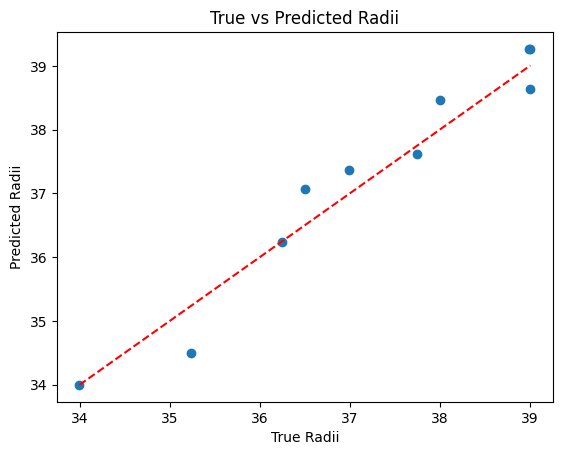

In [10]:


# Plot true vs predicted radii
plt.scatter(radii_test[:10], pred_crow[:10])
plt.plot([radii_test[:10].min(), radii_test[:10].max()], [radii_test[:10].min(), radii_test[:10].max()], color='r', linestyle='--')
plt.xlabel('True Radii')
plt.ylabel('Predicted Radii')
plt.title('True vs Predicted Radii')
plt.show()


In [5]:
print(radii_val[:10])

[[38.993984 ]
 [36.2506446]
 [36.5000622]
 [38.0001896]
 [38.9989406]
 [37.745165 ]
 [39.005028 ]
 [36.9944262]
 [35.2398808]
 [33.995009 ]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step


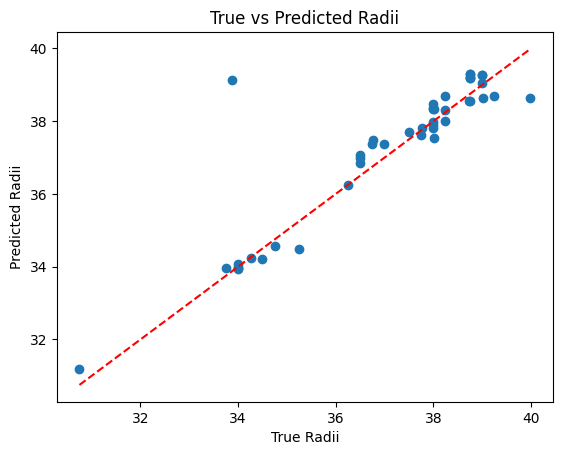

In [14]:
df = pd.read_excel('combined_results.xlsx')


image_paths = df['Image Path'].tolist()  
radii = df['circle_radius'].values       

img_height, img_width = 256, 256 #FIXED DImensions
images = []

for path in image_paths:
   
    img = load_img(path, target_size=(img_height, img_width), color_mode='grayscale')
    img_array = img_to_array(img) / 255.0  
    images.append(img_array)


images = np.array(images)  # Shape: (num_samples, img_height, img_width, 1)
radii = radii.reshape(-1, 1)  # Shape: (num_samples, 1)


x_train, x_val, radii_train, radii_val = train_test_split(
    images, radii, test_size=0.2, random_state=42
)

# autoencoder = load_model('diffraction_autoencoder.h5', custom_objects={'mse': MeanSquaredError()})
test_images = x_val
reconstructed_images, predicted_radii,pred_ccol,pred_crow = autoencoder.predict(test_images)


plt.scatter(radii_val, pred_crow)
plt.plot([radii_val.min(), radii_val.max()], [radii_val.min(), radii_val.max()], color='r', linestyle='--')
plt.xlabel('True Radii')
plt.ylabel('Predicted Radii')
plt.title('True vs Predicted Radii')
plt.show()


In [6]:
# image_path='./Results_Validation/VideoLarge/cropped_object_1/frame_000001.png_object1.png'
image_path='./Results_Validation/Video1/Video1/frame_000000.png'


img_height, img_width = 256, 256
img = load_img(image_path, target_size=(img_height, img_width), color_mode='grayscale')
img_array = img_to_array(img) / 255.0  
images=[]
images.append(img_array)


images = np.array(images)  # Shape: (num_samples, img_height, img_width, 1)

autoencoder = load_model('diffraction_autoencoder.h5', custom_objects={'mse': MeanSquaredError()})
# autoencoder = load_model('models/autoencoder_fold_1.h5', custom_objects={'mse': MeanSquaredError()})
# reconstructed_images, predicted_radii,pred_ccol,pred_crow = autoencoder.predict(images)
reconstructed_images, predicted_radii = autoencoder.predict(images)
print(autoencoder.predict(images))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
[array([[[[0.69375986],
         [0.8972644 ],
         [0.9143795 ],
         ...,
         [0.74877155],
         [0.80925876],
         [0.46352273]],

        [[0.98612595],
         [0.9959143 ],
         [0.9947234 ],
         ...,
         [0.96460515],
         [0.95579875],
         [0.76043564]],

        [[0.9853297 ],
         [0.99700695],
         [0.9949053 ],
         ...,
         [0.9688827 ],
         [0.9586825 ],
         [0.74726707]],

        ...,

        [[0.79743224],
         [0.93795884],
         [0.95212615],
         ...,
         [0.95546484],
         [0.93240297],
         [0.6836188 ]],

        [[0.79689103],
         [0.93485254],
         [0.9511635 ],
         ...,
         [0.94789594],
         [0.92060846],
         [0.74879473]],

        [[0.77464956],
         [0.8688004 ],
         [0.9056825 ],
         ...,
         [0.82574123],
         [0.7610431 ],
         

In [20]:
# image_path='./Results_Validation/VideoLarge/cropped_object_1/frame_000001.png_object1.png'
image_path='figure_with_border.png'


img_height, img_width = 256, 256
img = load_img(image_path, target_size=(img_height, img_width), color_mode='grayscale')
img_array = img_to_array(img) / 255.0  
images=[]
images.append(img_array)


images = np.array(images)  # Shape: (num_samples, img_height, img_width, 1)

autoencoder = load_model('diffraction_autoencoder.h5', custom_objects={'mse': MeanSquaredError()})
# autoencoder = load_model('models/autoencoder_fold_1.h5', custom_objects={'mse': MeanSquaredError()})
# reconstructed_images, predicted_radii,pred_ccol,pred_crow = autoencoder.predict(images)
reconstructed_images, predicted_radii = autoencoder.predict(images)
print(autoencoder.predict(images))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
[array([[[[0.9122953 ],
         [0.9972795 ],
         [0.9984712 ],
         ...,
         [0.9436715 ],
         [0.9770028 ],
         [0.4424829 ]],

        [[0.9999907 ],
         [0.99999964],
         [0.9999993 ],
         ...,
         [0.9997755 ],
         [0.99958605],
         [0.952387  ]],

        [[0.9999893 ],
         [0.9999998 ],
         [0.99999934],
         ...,
         [0.9998444 ],
         [0.9996598 ],
         [0.94265085]],

        ...,

        [[0.98774177],
         [0.9998157 ],
         [0.9999293 ],
         ...,
         [0.99999577],
         [0.99996465],
         [0.93737966]],

        [[0.987491  ],
         [0.9997388 ],
         [0.9999189 ],
         ...,
         [0.99999064],
         [0.9999324 ],
         [0.9877199 ]],

        [[0.9802666 ],
         [0.99701774],
         [0.99897915],
         ...,
         [0.9981694 ],
         [0.9869218 ],
         

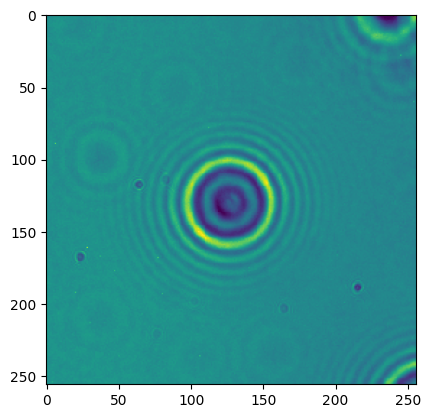

In [7]:
plt.imshow(img)
plt.show()

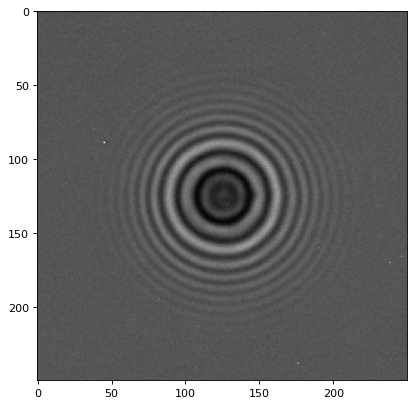

In [19]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from PIL import Image, ImageOps

# Load the image
image_path = './Results_Validation/Video1/Video1/frame_000001.png'
image_path='./Results_Validation/VideoLarge/cropped_object_1/frame_000000.png_object1.png'
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Grayscale image
img = img.astype('float32') / 255.0  # Normalize to 0-1 for matplotlib display

# Define the figure size to get 640x480 resolution
fig_dpi = 80  # Dots per inch (80 dpi -> 640x480 resolution)
fig_width, fig_height = 8, 6  # 8 inches * 80 = 640 pixels, 6 inches * 80 = 480 pixels

fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=fig_dpi)

# Display the image
ax.imshow(img, cmap='gray')


# Save the figure to ensure it has a resolution of 640x480
plt.savefig('figure_with_border.png', dpi=fig_dpi)

plt.show()


In [6]:
print(predicted_radii)

[[14.721905]]


In [3]:
import matplotlib.patches as patches

In [2]:
import cv2
from pathlib import Path

C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_9332\848373055.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


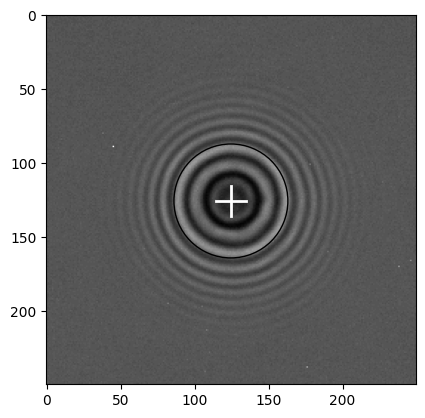

In [22]:
# image=reconstructed_images[0]
image = cv2.imread('./Results_Validation/VideoLarge/cropped_object_1/frame_000000.png_object1.png', cv2.IMREAD_GRAYSCALE)
# image = cv2.imread('./Results_Validation/Video1/Video1/frame_000001.png', cv2.IMREAD_GRAYSCALE)
ccol=124.50106
crow=125.49988
# plt.imshow(image2)
# plt.show()
# circle_radius=predicted_radii[0]
# circle_radius=pred_crow
fig, ax = plt.subplots()
ax.imshow(image, cmap='gray')
circle_center=(ccol,crow)
circle = patches.Circle(circle_center, predicted_radii, edgecolor='black', facecolor='none', linewidth=1)
ax.add_patch(circle)

cross_size = 10
ax.plot([circle_center[0] - cross_size, circle_center[0] + cross_size], 
            [circle_center[1], circle_center[1]], color='white', linewidth=2) 
ax.plot([circle_center[0], circle_center[0]], 
        [circle_center[1] - cross_size, circle_center[1] + cross_size], color='white', linewidth=2) 

fig.show()

